In [9]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("data.txt", header = None, sep = ' ', names  = ['A0', 'N1', 'STEP', 'AA', 'TIME', 'ALPHA', 'ITER'])

data

,A0,N1,STEP,AA,TIME,ALPHA,ITER
0,0.00433,700,0.015,1000000.0,0.00005,0.3,70000
1,0.00433,400,0.015,10000.0,0.00010,0.8,40000
2,0.00433,600,0.015,100000.0,0.00010,0.4,50000
3,0.00433,400,0.020,1000.0,0.00010,0.5,50000
4,0.00433,300,0.020,100.0,0.00010,0.5,50000


In [10]:
class variables:

    def __init__(self, experiment):
        self.exp = experiment
    
    def a0(self):
        return data['A0'][self.exp-1]
    
    def n1(self):
        return data['N1'][self.exp-1]
    
    def step(self):
        return data['STEP'][self.exp-1]
    
    def aa(self):
        return data['AA'][self.exp-1]
    
    def time(self):
        return data['TIME'][self.exp-1]
    
    def alpha(self):
        return data['ALPHA'][self.exp-1]
    
    def iter(self):
        return data['ITER'][self.exp-1]
    
    

def fifth_order_firstderivative(f, step):
    d = np.zeros(len(f))

    d[0] = (f[1]-f[0])/step
    d[1] = (f[2]-f[0])/(2*step)
    for i in range(2, len(f)-2):
        d[i] = (-f[i+2]+8*f[i+1]-8*f[i-1]+f[i-2])/(12*step)

    d[-2] = (f[-1]-f[-3])/(2*step)
    d[-1] = (f[-1]-f[-2])/step

    return d

def second_derivative(f, step):
    dd = np.zeros(len(f))

    dd[0] = (f[2]-2*f[1]+f[0])/(step**2)
    for i in range(1, len(f)-1):
        dd[i] =  (f[i+1]-2*f[i]+f[i-1])/(step**2)
    dd[-1] = (f[-3]-2*f[-2]+f[-1])/(step**2)

    return dd

def simpson_integration(f, step):

    # we will force an even number of points on f so that we can apply simpson second rule
    
    assert len(f)%2 == 1, 'f must have even number of points to apply simpson'
    integ = f[0]+f[-1]

    for i in range(1, len(f)-1, 2):
        integ += 4*f[i] + 2*f[i+1]

    integ += 4*f[-2]

    integ = (step/3)*integ

    return integ

def simpson_integration_v2(f, step):

    integ = (step/3)*(f[0] + 2*sum(f[:n-2:2]))

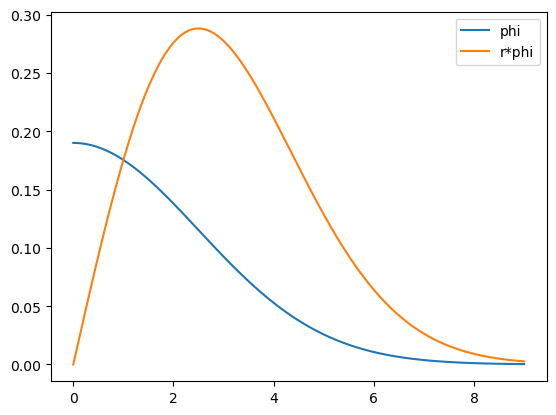

In [12]:
# We start initializing the wave function *r  
import math

var = variables(3)

a0 = var.a0()
n1 = var.n1()
step = var.step()
aa = var.aa()
time = var.time()
alpha = var.alpha()


C = (np.sqrt(alpha)**3)/np.sqrt(np.sqrt(np.pi))


phi_ini = np.array([C*math.exp(-0.5*(alpha**2)*((step*i)**2)) for i in range(n1+1)])
X = np.linspace(0, n1*step, n1+1)
R_ini = phi_ini*X

R = R_ini
phi = phi_ini


plt.plot(X, phi_ini, label='phi')

plt.plot(X, R_ini, label = 'r*phi')

plt.legend()

plt.show()

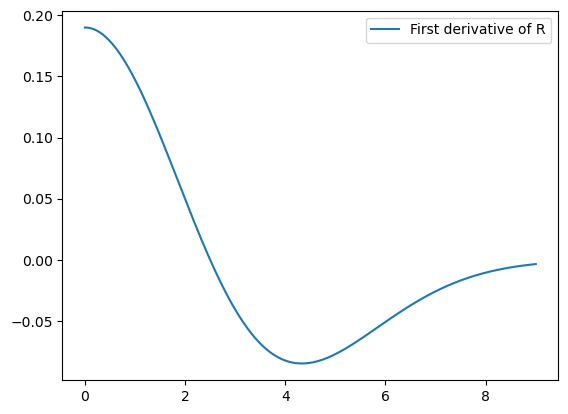

In [13]:
R_der = fifth_order_firstderivative(R, step)
plt.plot(X, R_der, label = 'First derivative of R')
plt.legend()

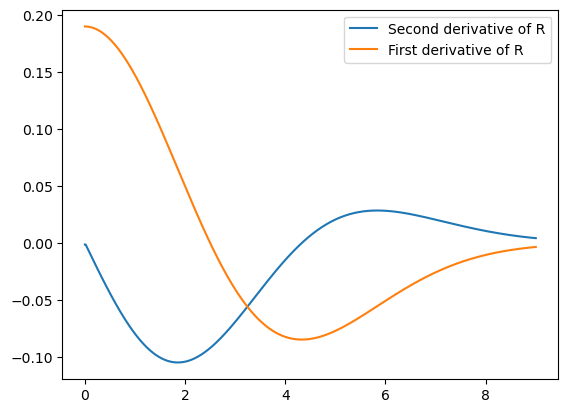

In [14]:
R_second_der = second_derivative(R, step)

plt.plot(X, R_second_der, label = 'Second derivative of R')
plt.plot(X, R_der, label = 'First derivative of R')

plt.legend()

In [15]:
simpson_integration(R, step)

1.1858919078476295